# Some tests/notes about python Dask

*Dask is a flexible parallel computing library for analytic computing.*
http://dask.pydata.org/en/latest/

In a few words, `Dask` is trying to port most of the Pandas and NumPy ecosystem to distributed computing systems.
It is meant to be simple with a minimal intrusion in usual codes.

`Dask` is convenient on a laptop. It is pure python, therefore it installs trivially with `conda` or `pip` and shifts the paradigm of datasets sizes from "fits in memory" to "fits on disk".

`Dask` can scale out to a cluster of 100s of machines. It is fault tolerant, elastic, data local, and low latency. For more information see documentation on the distributed scheduler.

In [1]:
# Loading configuration for the notebook. 
# BUG in osX el Capitan that limits to 256
# Remember to run before ipython.
# ulimit -n 4096

%pylab inline

# Mac retina and HiRes displays configuration
# make figures at 2x resolution on screen.
%config InlineBackend.figure_format='retina'

import pylab as plt
import numpy as np

# my configuration of mpl
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
rcParams['font.size'] = 14
rcParams["axes.titlesize"] = "x-large"
rcParams["axes.labelsize"] = "large"
rcParams["xtick.direction"] = "out"
rcParams["ytick.direction"] = "out"
rcParams["xtick.major.size"] = "8"
rcParams["xtick.minor.size"] = "4"
rcParams["ytick.major.size"] = "8"
rcParams["ytick.minor.size"] = "4"

Populating the interactive namespace from numpy and matplotlib


## Dask: a lightweight task graph generator with a strong core and high-level interfaces

`Dask` is a lightweight generator of task graphs for Python. 

Let see what that means.

In [2]:
import dask
from dask import array
import numpy as np

In [3]:
a = array.random.normal(0., 1, size=(int(1e2)), chunks=(2,))
b = array.random.normal(0, 0.3, size=(int(1e2),), chunks=(2,))
a, b

(dask.array<da.random.normal, shape=(100,), dtype=float64, chunksize=(2,)>,
 dask.array<da.random.normal, shape=(100,), dtype=float64, chunksize=(2,)>)

In [4]:
c = ((a - b) ** 2 / 0.3 ** 2).sum(0)
c

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

Note that nothing has happened yet. Operations are stored in some functional trees but no computation has actually been done so far.

A task graph is a way of describing a sequence of operations so that they can be executed at a later point. By building these task graphs, `Dask` describes the exact sequence of inputs, operations, and outputs that your algorithm requires, and can send this description to a variety of backends for efficient parallel and/or out-of-core computation.

* `dask.bag`: create task graphs using a functional programming style
* `dask.array`: create task graphs using a NumPy-like array interface
* `dask.dataframe`: create task graphs using a Pandas-like DataFrame interface

Each of these provides a familiar `Python` interface for operating on data, with the difference that individual operations build graphs rather than computing results.

The results must be explicitly extracted with a call to the `compute()` method.

In [5]:
%timeit c.compute()

42.6 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
c.visualize()

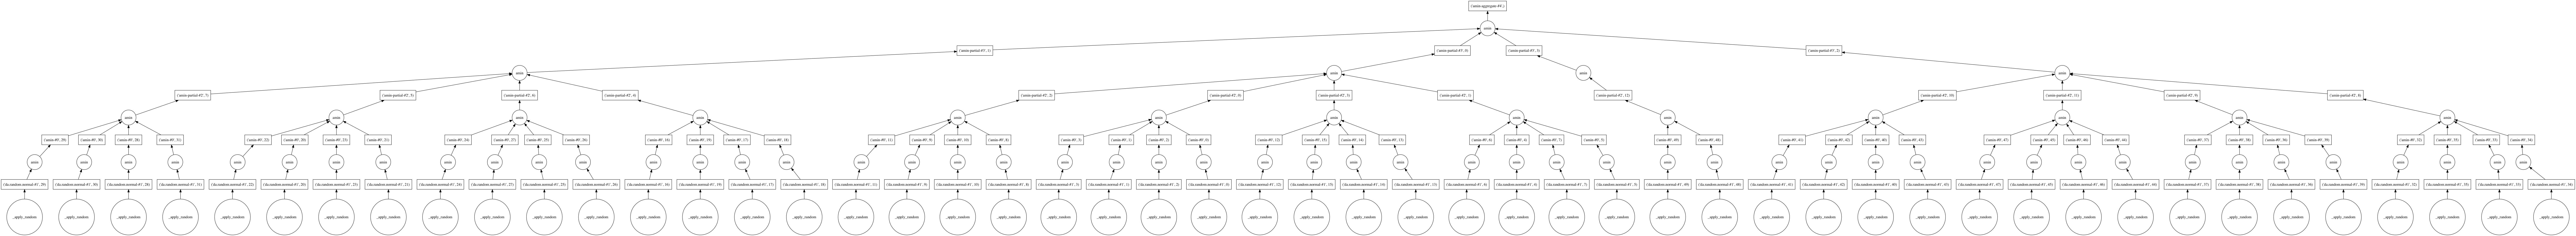

In [7]:
a.min().visualize()

**A bit more data to chew on**

Let's go for bigger sets of data to get an idea of performance.

In [8]:
a = array.random.normal(0., 1, size=(int(1e4), int(1e4)), chunks=(1000, 1000))
b = array.random.normal(0, 0.3, size=(int(1e4),), chunks=(1000,))

In [9]:
a, b

(dask.array<da.random.normal, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000)>,
 dask.array<da.random.normal, shape=(10000,), dtype=float64, chunksize=(1000,)>)

In [10]:
c = ((a - b) ** 2 / 0.3 ** 2).sum(0)
c

dask.array<sum-aggregate, shape=(10000,), dtype=float64, chunksize=(1000,)>

In [11]:
%timeit  c.compute(get=dask.get)   # forcing single CPU mode (may not be default)

4.72 s ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we let Dask decide the computation time changes.

In [12]:
%timeit c.compute()

1.03 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Do we gain anything compared with numpy?

In [13]:
na = np.array(np.random.normal(0, 1,size=(int(1e4), int(1e4))))
nb = np.array(np.random.normal(0, 0.3,size=(int(1e4))))

In [14]:
%timeit c = ((a - b) ** 2 / 0.3 ** 2).sum(0)

3.78 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Of course there is an overhead. Each computation basically builds a graphical operation model that is optimized/compiled and then executed.

However, the previous test with numpy is not really a fair comparison... `np.random.normal` had been triggered once, and only the final operation was actually timed.

In [15]:
%%time
na = np.array(np.random.normal(0, 1,size=(int(1e4), int(1e4))))
nb = np.array(np.random.normal(0, 0.3,size=(int(1e4))))
c = ((a - b) ** 2 / 0.3 ** 2).sum(0)

CPU times: user 3.79 s, sys: 557 ms, total: 4.35 s
Wall time: 4.35 s


Now we get something much more interesting... Dask is very comparable on a single CPU. Though scaling up the computations to many CPUs with Dask becomes trivial.

# Dask: Scaling out to multiple CPUs

There are many possibilities to scale the computations. First one can scale up the codes, meaning optimizing, switching parts to better suited languages (C/Cython, GPUs ...). Second one can also scale out the computations, which means distributing the code to multiple CPUs/machines.

Out of the box, one can leverage multiple CPUs from their local machine with `Dask`.

In the above, one could replace `dask.get` by `dask.multiprocessing.get` for instance, which uses the built-in python multiprocessing package.

Another option is to use Dask scheduler options.

In [16]:
from distributed import LocalCluster
cluster = LocalCluster()

Dask comes with a monitor that runs in the background at http://localhost:8787/status

In principle Dask automatically finds the `cluster` and will use it as default for computations. But you may need to be a bit more explicit with other schedulers.

Therefore, you will need to use a `client`

In [17]:
from dask.distributed import Client

client = Client(cluster)

clients have a `get` method that can be used as before. Also one can use `dask.set_options`. Below I explicitly use the `client.compute` method.

In [18]:
%%time
a = array.random.normal(0., 1, size=(int(1e4), int(1e4)), chunks=(1000, 1000))
b = array.random.normal(0, 0.3, size=(int(1e4),), chunks=(1000,))
task = client.compute(((a - b) ** 2 / 0.3 ** 2).sum(axis=0) )

CPU times: user 42.3 ms, sys: 11.2 ms, total: 53.5 ms
Wall time: 52.8 ms


Did you see the activity on the scheduler monitor?

In [19]:
task

<Future: status: pending, key: finalize-2af920eb1f8b80297636eba7d80bc593>

`task` is now a proxy to the computations like any multiprocessing interface in python. Calling the result is therefore a barrier lock.

In [20]:
task.result()

array([ 135715.9361188 ,  120720.3106138 ,  114703.89530621, ...,
        111978.6059641 ,  116800.89882229,  125543.01877221])

Did you see how long it takes to do the full computations? also the memory is not filled up... 

In [21]:
%%time
for _ in range(10):
    a = array.random.normal(0., 1, size=(int(1e4), int(1e4)), chunks=(1000, 1000))
    b = array.random.normal(0, 0.3, size=(int(1e4),), chunks=(1000,))
    task = client.compute(((a - b) ** 2 / 0.3 ** 2).sum(axis=0) )
    task.result()

CPU times: user 9.65 s, sys: 1.06 s, total: 10.7 s
Wall time: 16.7 s


# TGAS and Dask

An exploration of Dask for analyzing the TGAS many csv files. (This extends easily to larger datasets like `Gaia_source`).

Let's read all the csv files in the directory or all the hd5 files. For the later, `lock=False` allows multiple concurrent access to the data. (because we are only reading, that's safe).

In [22]:
from dask import dataframe as dd
d = dd.read_csv('./TgasSource_*.csv')
# d = dd.read_hdf('tmp.hd5', '/data', lock=False, chunksize=10)
d

Dask DataFrame Structure:
                    hip tycho2_id solution_id source_id random_index ref_epoch       ra ra_error      dec dec_error parallax parallax_error     pmra pmra_error    pmdec pmdec_error ra_dec_corr ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr astrometric_n_obs_al astrometric_n_obs_ac astrometric_n_good_obs_al astrometric_n_good_obs_ac astrometric_n_bad_obs_al astrometric_n_bad_obs_ac astrometric_delta_q astrometric_excess_noise astrometric_excess_noise_sig astrometric_primary_flag astrometric_relegation_factor astrometric_weight_al astrometric_weight_ac astrometric_priors_used matched_observations duplicated_source scan_direction_strength_k1 scan_direction_strength_k2 scan_direction_strength_k3 scan_direction_strength_k4 scan_direction_mean_k1 scan_direction_mean_k2 scan_direction_mean_k3 scan_direction_mean_k4 phot_g_n_obs phot_g_mean_flux phot_g_mean_flux_error phot_g_mean_mag phot_variable_flag        l        b  ecl_lon  ecl_lat
npartitions=31                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
None            float64    object       int64     int64        int64   float64  float64  float64  float64   float64  float64        float64  float64    float64  float64     float64     float64          float64      float64       float64           float64       float64        float64            float64             float64         float64                int64                int64                     int64                     int64                    int64                    int64             float64                  float64                      float64                     bool                       float64               float64               float64                   int64                int64              bool                    float64                    float64                    float64                    float64                float64                float64                float64                float64        int64          float64                float64         float64             object  float64  float64  float64  float64
None                ...       ...         ...       ...          ...       ...      ...      ...      ...       ...      ...            ...      ...        ...      ...         ...         ...              ...          ...           ...               ...           ...            ...                ...                 ...             ...                  ...                  ...                       ...                       ...                      ...                      ...                 ...                      ...                          ...                      ...                           ...                   ...                   ...                     ...                  ...               ...                        ...                        ...                        ...                        ...                   

One can already see that `Dask` decides on it's own for a default splitting scheme of the data that is not just imposed by storage.

Let's make the map-reduce code: for any chunck of data (`Dask` will figure that segmentation) generate an histogram on the sky, then sum the counts.

In [23]:
from dask import delayed

# declare the mapping
dx = 0.3
dy = 0.3
bins = np.arange(0,360, dx), np.arange(-90, 90, dy)


@delayed(pure=True)
def map2d(c, **args):
    n, bx, by = np.histogram2d(c.l, c.b, bins=bins)
    return n, bx, by


@delayed(pure=True)
def reduce(chunks):
    return sum(xk[0] for xk in chunks)

Note: the `delayed` decorator takes a `pure` keyword. It relates to pre-compiling the functions or not. Setting the keyword makes sure all arguments are considered to change during the processing.

Before any hard work, we define the operations such that `Dask` can do it's magic.

We first delay the reading of the data to when it is best, on each part of the data, we can apply the `map` function, then `reduce`.
Note: `Python 3` default behavior is to use generators. This does not always plays well with `Dask.delayed`. At this stage, it is still cost free to compute the result of `map` as no real calculations are made yet.

In [24]:
parts = d.to_delayed()
chunks = list(map(map2d, parts))
result = reduce(chunks)
result

Delayed('reduce-d6441b45468ad90b02e2eb08ad8789ba')

The magic behind can be shown on the final result, where we clearly see the map-reduce structure and the different parts of the calculations.

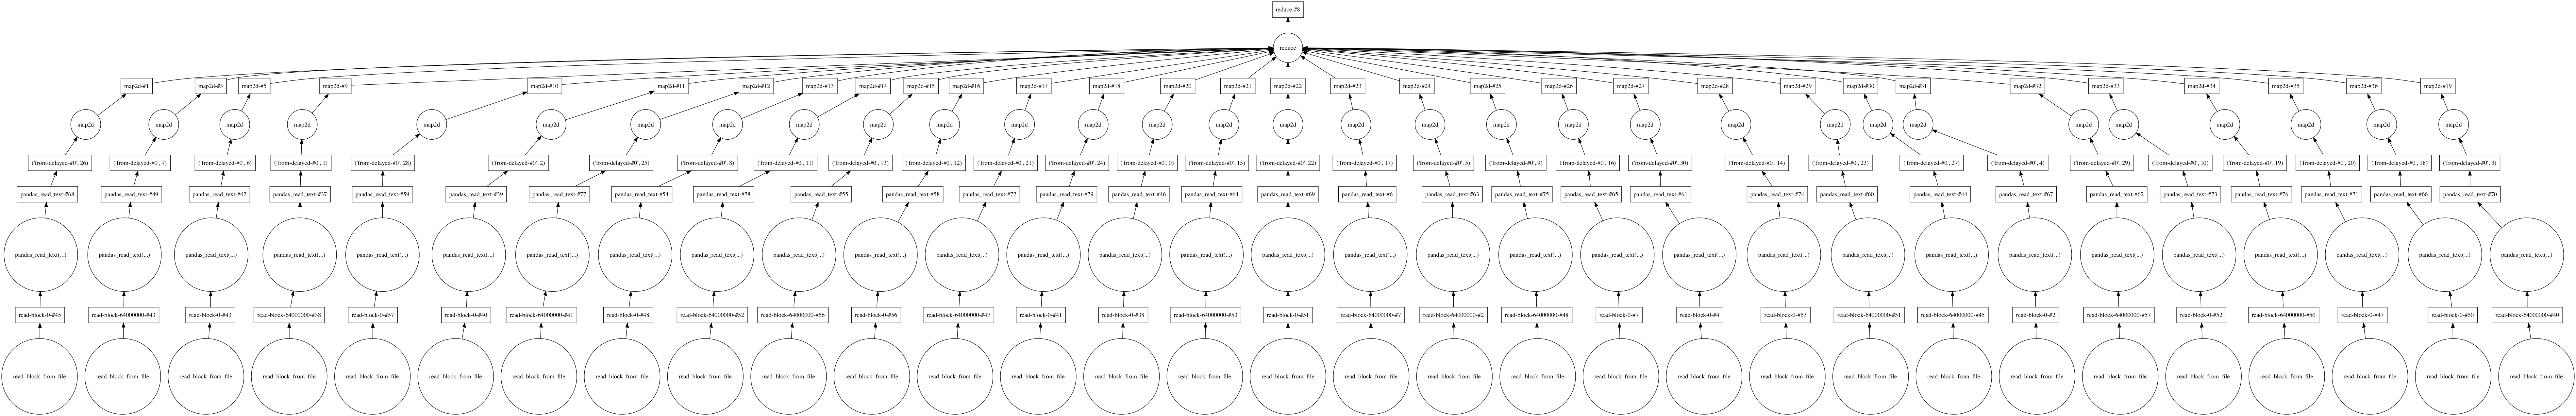

In [25]:
result.visualize()

`Dask` could start working already. But in this case we want to leverage the parallel processing using the `Scheduler`. 

In [26]:
%%time
r = client.compute(result).result()

CPU times: user 1.6 s, sys: 240 ms, total: 1.84 s
Wall time: 11.7 s


After some polishing for plotting

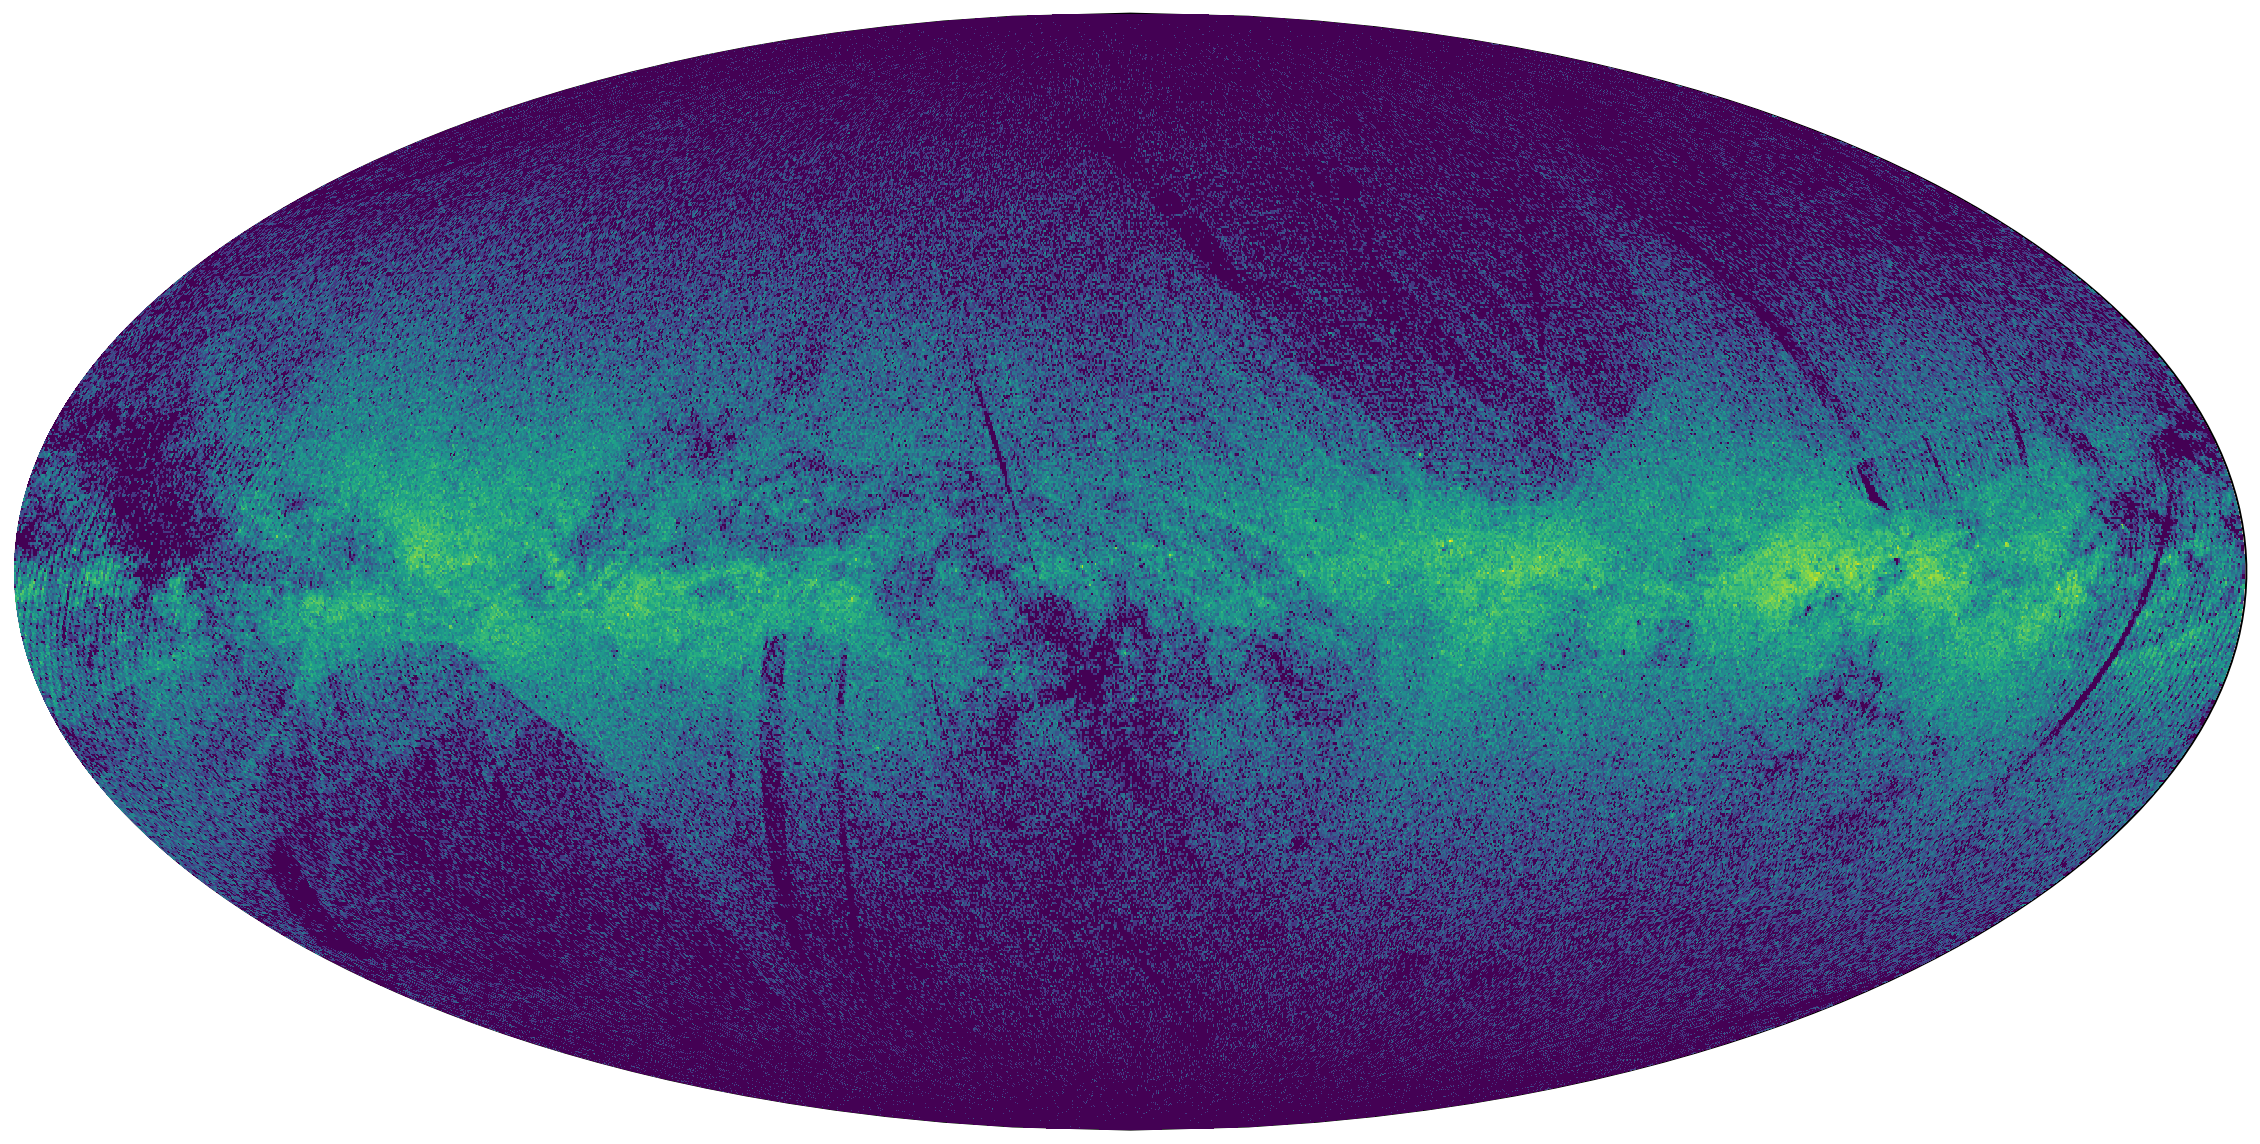

In [27]:
from mpl_toolkits.basemap import Basemap
from matplotlib import ticker
import matplotlib.patheffects


def get_radec_basemap(projection='moll', resolution='c', 
                      lon_0=0, labels=False, meridians=False, **kwargs):
    """ Generate a Basemap for angular plot

    Parameters
    ----------
    projection: string
        projection name (see: :class:`basemap.Basemap`)

    resolution: string
        resolution of the projection (see: :class:`basemap.Basemap`)

    lon_0: float
        origin of the reference (see: :class:`basemap.Basemap`)

    kwars: dict
        forwarded to :func:`Basemap`

    returns
    -------
    m: Basemap instance
        result from :func:`Basemap`
    """
    # generate the basemap for the plot
    m = Basemap(projection=projection,
                lon_0=lon_0,
                resolution=resolution, **kwargs)

    m.drawmapboundary(fill_color='white')

    if meridians is True:
        m.drawmeridians(np.arange(-180, 180, 360. / 24. * 3.),
                        labels=[0, 0, 0, 0],
                        color='black',
                        dashes=[1,1],
                        labelstyle='+/-',
                        linewidth=0.1)
        if labels is True:
            m.drawparallels(np.arange(-90, 91, 20),
                            labels=[1,0,0,0],
                            color='black',
                            dashes=[1,1],
                            labelstyle='+/-',
                            linewidth=0.1)
        else:
            m.drawparallels(np.arange(-90, 91, 20),
                            labels=[0,0,0,0],
                            color='black',
                            dashes=[1,1],
                            labelstyle='+/-',
                            linewidth=0.1)

    # add manually the meridian labels for this projection
    if labels is True:
        ef = matplotlib.patheffects.withStroke(foreground="w", linewidth=3)
        for k in np.arange(-180, 181, 360. / 24. * 3.):
            val = int(k / 360. * 24.)
            x, y = m(k, 0)
            plt.text(x, y, '{0:+d}h'.format(val), path_effects=[ef],
                     ha='center', va='center')

    return m


def plot_ra_dec_histogram2d(density, ra_bins, dec_bins, projection='moll',
                            resolution='c', lon_0=0, cmap=plt.cm.viridis,
                            vmin=None, vmax=None, basemap=None, labels=False,
                            **kwargs):
    """
    Plot an histogram2d in a projected system of coordinates

    Parameters
    ----------
    density: ndarray, (nx, ny)
        density map

    ra_bins: ndarray, (nx,)
        ra bin edges

    dec_bins: ndarray, (ny, )
        dec bin edges

    projection: string
        projection name (see: :class:`basemap.Basemap`)

    resolution: string
        resolution of the projection (see: :class:`basemap.Basemap`)

    lon_0: float
        origin of the reference (see: :class:`basemap.Basemap`)

    cmap: plt.colormap
        colormap for :func:`plt.pcolormesh`

    vmin: float
        minimum value to show

    vmax: float
        maximum value to show

    kwars: dict
        forwarded to :func:`plt.pcolormesh`

    returns
    -------
    r: [patches]
        result from :func:`plt.pcolormesh`
    """

    # generate the basemap for the plot
    if basemap is None:
        basemap = get_radec_basemap(projection=projection, lon_0=lon_0,
                                    resolution=resolution, labels=labels)

    dec_bins_2d, ra_bins_2d = np.meshgrid(dec_bins, ra_bins)
    # convert the xs and ys to map coordinates
    xs, ys = basemap(ra_bins_2d, dec_bins_2d)
    if vmin is None:
        vmin = np.nanmin(density)
    if vmax is None:
        vmax = np.nanmax(density)
    r = plt.pcolormesh(xs, ys, density, cmap=cmap, vmin=vmin, vmax=vmax,
                       **kwargs)
    return r


plt.figure(figsize=(20,20))
im = np.log10(r + 1e-3)
plot_ra_dec_histogram2d(im, bins[0] - 180, bins[1], vmin=0);

Remember to close the pool at some point (does not have to be exactly here and now.)

# Example: Lennard-Jones potential

https://en.wikipedia.org/wiki/Lennard-Jones_potential

The Lennard-Jones potential (1924) is a mathematically simple model that approximates the interaction between a pair of neutral atoms or molecules. 
The most common expressions of the L-J potential are:

\begin{align}
V_{\mathrm {LJ}} =& 4\,\varepsilon\, \left[\left({\frac{\sigma }{r}}\right)^{12}-\left({\frac{\sigma }{r}}\right)^{6}\right]\\
                   =& \varepsilon\, \left[\left({\frac {r_{\mathrm {m} }}{r}}\right)^{12}-2\left({\frac {r_{\mathrm{m} }}{r}}\right)^{6}\right], 
\end{align}
where $\varepsilon$ is the depth of the potential well, $\sigma$ is the finite distance at which the inter-particle potential is zero, $r$ is the distance between the particles, and $r_m $is the distance at which the potential reaches its minimum. 
At $r_m$, the potential function has the value $-\varepsilon$. The distances are related as $r_m = 21 / 6\,\sigma \approx 1.122 \sigma$. These parameters can be fitted to reproduce experimental data or accurate quantum chemistry calculations. Due to its computational simplicity, the Lennard-Jones potential is used extensively in computer simulations even though more accurate potentials exist.

**Numpy based version**

In [28]:
def make_cluster(natoms, radius=40, seed=1924):
    """ make a random collection of particles """
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms, 3)) - 0.5
    return cluster

def lj(r2):
    sr6 = (1. / r2) ** 3
    pot = 4. * (sr6 * sr6 - sr6)
    return pot

def distances(cluster):
    """build the matrix of distances"""
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff * diff).sum(-1)
    return mat

def potential_np(cluster):
    """
    the lj function is evaluated over the upper triangle
    after removing distances near zero
    """
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [29]:
cluster_np = make_cluster(int(7e3), radius=500)

In [30]:
%time 
potential_np(cluster_np)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


-0.21282893668845293

Where do we spend much of the time? 

In [31]:
#%load_ext snakeviz
#%snakeviz potential(cluster)

**Dask version**

Only the potential function needs to be rewritten to best utilize `Dask`.
Note that `dask.array.nansum` is used over the full $NxN$ distance matrix to improve parallel efficiency.

In [32]:
def potential_dask(cluster):
    """ compute the potential on the entire
    matrix of distances and ignore division by zero
    """
    d2 = distances(cluster)
    energy = dask.array.nansum(lj(d2)) / 2.
    return energy

We can reuse the same variables/cluster as before by converting the NumPy array to dask (since it fits into memory).
We can also optimize the segmentation of the data by chunking the array by number of CPU cores.

In [33]:
from os import cpu_count

cluster_dask = dask.array.from_array(cluster_np, chunks=cluster_np.shape[0] // cpu_count())
energy_dask = potential_dask(cluster_dask)

In [34]:
%time
energy_dask.compute()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


-0.21282893668845304

In [35]:
cluster.close()

distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - INFO - Reconnecting...


# Dask SGE Scheduler

my version of dasksge is now out of date and I recommend https://github.com/dask/dask-drmaa

From the above one only needs to replace the scheduler to use one that leverages the queue system.

```python
from dask_drmaa import DRMAACluster
cluster = DRMAACluster()
cluster.start_workers(20)

from dask.distributed import Client
client = Client(cluster)
```